# Posterior and Marginal distributions

This notebook is the continuation of `bandwidths.ipynb` notebook, apliying the bw results and the class for get the n-dimentional PDF. 

#### Some considerations: 
1. As **prior** information we will take the cleaned (without NaN or inf values) information from exoplanet.eu, this is the first part of notebook.

2. The PDF from `oiptimal_pdf` class  fulfills the functions of **likelihood** for a certain number of variables in synthetic systems with no-pertutbation, low perturbation and high perturbation. 

3. To get the **marginal** distributions of a variable of interest, we go in the same way that the example marginalization in the notebook `3D.ipynb`.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

In [2]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## 1. Data Cleaning

### 1.1 Simulation data   

see the notation according to <a href="https://github.com/saint-germain/population_synthesis/blob/master/README.md ">Readme.md</a> from `Population_synthesis` project.





In [3]:
#========================== Simulation Data ==========================
dn=pd.read_csv('data/proc_no_pert.csv',index_col=None); dn["gia"]=dn.ngi>0 #without pertubtations 
dl=pd.read_csv('data/proc_lo_pert.csv',index_col=None); dl["gia"]=dl.ngi>0 #with low pertubtations 
dh=pd.read_csv('data/proc_hi_pert.csv',index_col=None); dh["gia"]=dh.ngi>0 #with high pertubtations

In [4]:
#======================= Simulation variables ========================
##Terrestrial: t; giant;g
dnt=dn[~dn["gia"]]; dng=dn[dn["gia"]] # without pertubtations 
dlt=dl[~dl["gia"]]; dlg=dl[dl["gia"]] # low pertubtations 
dht=dh[~dh["gia"]]; dhg=dh[dh["gia"]] # high pertubtations 

x_variables = [dng,dlg,dhg,dnt,dlt,dht,dn,dl,dh]

for i, var in enumerate(x_variables):
    var['logeff'] = np.log10(var.massefficiency)
    var['logcom'] = np.log10(var.com)

In [5]:
dnt.head()

,Unnamed: 0,ident,com,nplanets,massbudget,massefficiency,sigmag0,md,rc,ms,metal,taugas,qest,ngi,mtr,apert,gia,logeff,logcom
1,1,5.0,2.932894,12.0,17.882769,0.000488,102.431593,0.110,38.977428,1.075269,-0.150160,1.014449e+06,5.464831,0.0,17.882769,0.0,False,-3.311837,0.467296
3,3,8.0,5.740174,9.0,8.166382,0.000163,62.737337,0.150,58.158928,1.076658,-0.282408,6.017040e+06,4.704798,0.0,8.166382,0.0,False,-3.786940,0.758925
5,5,15.0,8.394027,8.0,16.003091,0.000436,106.824759,0.110,38.167542,0.986003,0.388613,2.435406e+06,5.218175,0.0,16.003091,0.0,False,-3.360068,0.923970
6,6,16.0,4.289089,24.0,12.426573,0.000219,118.543720,0.170,45.042137,1.258747,-0.352459,1.107032e+06,4.469478,0.0,12.426573,0.0,False,-3.658976,0.632365
7,7,17.0,3.771156,12.0,16.762554,0.000811,35.587738,0.062,49.645451,0.739731,0.121866,9.050091e+06,7.257983,0.0,16.762554,0.0,False,-3.090930,0.576474


### 1.2 Observational data 

Data get from <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [6]:
data_o = pd.read_csv('data/exoplanet.eu_catalog.csv', 
                       usecols = ['mass','mass_error_min','semi_major_axis','semi_major_axis_error_min','star_name',
                                  'star_metallicity','star_metallicity_error_min','star_mass','star_mass_error_min'])

data_o = data_o.replace([np.inf, -np.inf], np.nan) 
data_o = data_o.replace([0], np.nan)
data_o = data_o.dropna()

In [7]:
data_o = data_o[['star_name','mass','mass_error_min', 'semi_major_axis', 'semi_major_axis_error_min', 
                 'star_metallicity', 'star_metallicity_error_min', 'star_mass', 'star_mass_error_min']]

data_o = data_o.assign(CM_i = data_o["semi_major_axis"]*data_o["mass"])
data_o = data_o.assign(dCM_i= data_o["CM_i"]*(data_o["mass_error_min"].divide(data_o["mass"])+data_o["semi_major_axis_error_min"].divide(data_o["semi_major_axis"])))

In [8]:
number=(data_o["star_name"].value_counts()).to_frame()

In [9]:
def NewData(data):
   
    p_system = data.groupby("star_name")
    
    Mtp   = p_system['mass'].sum();             dMtp   = p_system['mass_error_min'].sum();  
    ms    = p_system['star_mass'].mean();        dms    = p_system['star_mass_error_min'].mean()
    metal = p_system['star_metallicity'].mean(); dmetal = p_system['star_metallicity_error_min'].mean()
    
    
    CoM  = p_system['CM_i'].sum().divide(p_system["mass"].sum())
    dCoM = CoM*((p_system['dCM_i'].sum()/p_system['CM_i'].sum()) + (p_system['mass_error_min'].sum())/p_system['mass'].sum())
    
    NewData = pd.DataFrame({'sys_name':list(p_system.groups.keys()),
                            'Mtp':Mtp, 'dMtp':dMtp,
                            'com':CoM.tolist(), 'dcom':dCoM.tolist(), 
                            'ms':ms, 'dms':dms, 'metal':metal, 'dmetal':dmetal})
    return NewData

In [10]:
obs_data = NewData(data_o)
obs_data = obs_data.assign(n_planets = number)
obs_data = obs_data.sort_values(by=['n_planets'], ascending=False)
obs_data.head()

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
TRAPPIST-1,TRAPPIST-1,0.017701,0.010374,0.029040,0.034407,0.080,0.007,0.04,0.08,7
K2-138,K2-138,0.113900,0.030500,0.083596,0.053756,0.930,0.060,0.16,0.04,6
GJ 876,GJ 876,2.861000,0.045000,0.185302,0.005413,0.334,0.030,0.05,0.20,4
WASP-47,WASP-47,2.511800,0.097400,0.760462,0.220362,1.110,0.490,0.18,0.07,4
Kepler-289,Kepler-289,0.451000,0.077000,0.489512,0.184174,1.080,0.020,0.05,0.04,3


In [11]:
#system_i = data_o[data_o.star_name == "Kepler-289"]  
#system_i

## 2. Posterior probability 

At first example we take the system "Kepler-289" to get the prior information of stellar mass `ms` and its metallicity `metal`, reported in the catalog of <a href="http://exoplanet.eu/">exoplanet.eu</a>

In [12]:
systm = obs_data[obs_data.sys_name == "Kepler-289"] 
systm

,sys_name,Mtp,dMtp,com,dcom,ms,dms,metal,dmetal,n_planets
star_name,,,,,,,,,,
Kepler-289,Kepler-289,0.451,0.077,0.489512,0.184174,1.08,0.02,0.05,0.04,3


### 2.1 Likelihood
In our formalism, for a variable of interest $x^i_k$, the likelihood of $x^i_k$ given $\boldsymbol\gamma^i$, comes from the model as the sum over unknown parameters $\boldsymbol\alpha^i_k$,

$$p\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right)= \int p_{\text{model}}\left(x^{i}_k, \boldsymbol\alpha^{i}_k \mid \boldsymbol\gamma^{i}\right) d\boldsymbol\alpha^{i}_k.$$

This is implemented in the notebook `optimal_pdf`.

In [13]:
import nbimporter
from bandwidths import optimal_pdf #import the class for get the pdf.

Importing Jupyter notebook from bandwidths.ipynb


In this example we take the variables `dng.ms`, `dng.metal` and `dng.nplanets` 

In [14]:
likelihood = optimal_pdf(dng.ms, dng.metal, dng.nplanets)
likelihood.pdf()

In [30]:
#Lkepler_289 = kepler_289.pdf_std/kepler_289.pdf_std.sum()

### 2.2 Prior infromation

The prior information $p(\boldsymbol\gamma^{i})$ comes from observations of individual known properties in the pseudovector $\boldsymbol\gamma^{i}$.

To generate a 2D prior $p(\boldsymbol\gamma^{i})$, we multiply a 2D matrix of ones times each prior. Here, we multiply the first prior normaly but for the second prior it is necessary to transpose the previous result. 

$$\text{prior} = ((1_{n\times n}\times Px_n)^{t}\times Py_n)^{t}$$

Finally, we transpose the result to get the prior distribution. For more dimensions the process is the same

In [17]:
from scipy.stats import truncnorm

In [87]:
# per data needs a list with [mu, sigma]: 

class prior(optimal_pdf):
    
    def __init__(self, likelihood, *args):
        self.org_data = np.array(args)
        self.pdfs = [] 
            
    def prior_pdf(self):
        for i in range(len(self.org_data)):
            pdf = stats.norm.pdf(likelihood.std_interval[i], 
                                 loc = self.org_data[i][0], 
                                 scale = self.org_data[i][1])       
            self.pdfs.append(pdf)
            
        if len(self.org_data) == 2:
            M_ones = np.ones([likelihood.lenght, likelihood.lenght]) 
            prior = ((M_ones*self.pdfs[0]).T*self.pdfs[1]).T     
            
            self.pdf_prior = prior
        
        elif len(self.org_data) == 3: 
            M_ones = np.ones([likelihood.lenght, likelihood.lenght, likelihood.lenght])    
            prior = (((M_ones*self.pdfs[0]).T*self.pdfs[1]).T*self.pdfs[2]).T 
        
            self.pdf_prior = prior

In [88]:
prueba = prior(likelihood, [systm.ms, systm.dms], [systm.metal,systm.dmetal])
prueba.prior_pdf()

Text(0, 0.5, 'stellar mass')

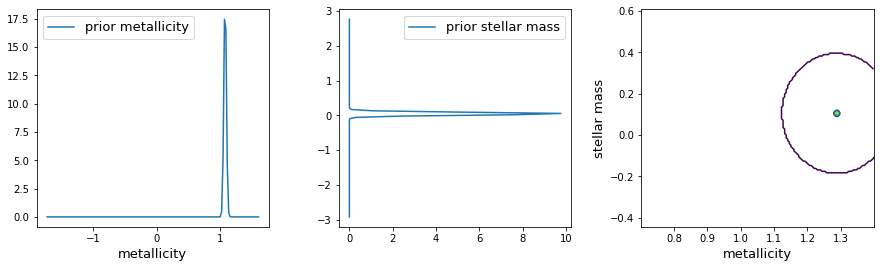

In [119]:
fig, ax = plt.subplots(1, 3, figsize=(15,4))
fig.subplots_adjust(wspace=.3)
lat = 13
#1
ax[0].plot(likelihood.std_interval[0], prueba.pdfs[0], label = "prior metallicity")
ax[0].set_xlabel("metallicity", fontsize =lat)
ax[0].legend(fontsize =lat)
#2
ax[1].plot(prueba.pdfs[1], likelihood.std_interval[1], label = "prior stellar mass")
ax[1].legend(fontsize =lat)
#3
ax[2].contour(likelihood.real_interval[0], likelihood.real_interval[1], prueba.pdf_prior)
ax[2].set_xlabel("metallicity", fontsize =lat)
ax[2].set_ylabel("stellar mass", fontsize =lat)


### 2.3 Posterior and marginal distributions

#### Posterior

The posterior distribution comes form Bayes Theorem, then in our formalims:

$$p^\prime\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right) \propto p\left(x^{i}_k \mid \boldsymbol\gamma^{i}\right) p(\boldsymbol\gamma^{i})$$

In therms of the length of data 

$$\boxed{\text{posterior}_{lmn} \propto \text{likelihood}_{lmn} \times \text{prior}_{mn}}$$

Sum the posterior over $l$ is the `axis=0`, $n$ means the `axis=1` and $n$ is the `axis=2`. Finally if we normalize the posterior the above equation becomes into equality.  

So, the posterior is the product of a likelihood with shape $l=100$, $m=100$ and $n=100$ times the prior with shape $m=100$ and $n=100$: 

In [ ]:
# likelihood is an object from "class optimal_pdf"
# prior is an object from class "prior"

def posterior(likelihood,prior):
    
    diff = [likelihood.data_std[:,i][1] - likelihood.data_std[:,i][0] for i in range(len(likelihood.data_std[0]))] 

    post = (likelihood.pdf_std.T*prior.prior_pdf.T).T
    
    
    if likelihood.dim == 3:
        norm = ((post.sum(axis=0)*(diff[0])).sum(axis=0)*(diff[1])).sum()*(diff[2])
    
    elif likelihood.dim == 4:
        norm = (((post.sum(axis=0)*(diff[0])).sum(axis=0)*(diff[1])).sum(axis=0)*(diff[2])).sum()*diff[3]
    
    
    return post/norm

In [ ]:
post = posterior(likelihood, prior)

In [ ]:
dx = likelihood.data_std[:,0][1] - likelihood.data_std[:,0][0]
dy = likelihood.data_std[:,1][1] - likelihood.data_std[:,1][0]
dz = likelihood.data_std[:,2][1] - likelihood.data_std[:,2][0]

((post.sum(axis=0)*(dx)).sum(axis=0)*(dy)).sum()*(dz) 

#### Marginal distriution 

The parginal distribution for a variable of interest is, 

$$p\left(x^{i}_{k}\right)=\int p\left(x^{i}_{k} \mid \boldsymbol\gamma^{i}\right) p(\boldsymbol\gamma^{i})\ d\boldsymbol\gamma^{i}.$$

in other words, 

$$p\left(x^{i}_{k}\right)=\sum_{j=1}^{n} p\left(x^{i}_{k_j} \mid \boldsymbol\gamma^{i}_j\right) p\left(\boldsymbol\gamma^{i}_j\right)\ \Delta \boldsymbol\gamma^{i}_j.$$



In our example, we take stellar mass, metallicity and number of planets. The likelihood came from giant planets obervations without perturbations in its disk structure. 

We will get the marginal distribution $p(x^i_k)$ for our variable of interest $x^{i}_k$ which is the number of planets in the system "Kepler-289".







In [ ]:
def marginal(posterior, likelihood):
    
    diff = [likelihood.data_std[:,i][1] - likelihood.data_std[:,i][0] for i in range(len(likelihood.data_std[0]))] 
    print(diff)
    M = (posterior.sum(axis=0)*diff[0]).sum(axis=0)*diff[1]
    
    return M
    

In [ ]:
Np_marginal = marginal(post, likelihood)

In [ ]:
plt.plot(likelihood.real_interval[2], Np_marginal, label="p(nplanets)")
plt.xlabel("nplanets")
plt.ylabel("Distribution")
plt.legend()

with perturbations

In [ ]:
#likelihood2 = optimal_pdf(dlg.ms, dlg.metal, dlg.nplanets)
#likelihood2.pdf()

In [ ]:
likelihood2.pdf_std.shape

In [ ]:
prior.prior_pdf.shape

In [ ]:
post2 = (likelihood2.pdf_std.T*prior.prior_pdf.T).T

In [ ]:
dx2 = likelihood2.data_std[:,0][1] - likelihood2.data_std[:,0][0]
dy2 = likelihood2.data_std[:,1][1] - likelihood2.data_std[:,1][0]
dz2 = likelihood2.data_std[:,2][1] - likelihood2.data_std[:,2][0]

In [ ]:
norm = ((post2.sum(axis=0)*(dx2)).sum(axis=0)*(dy2)).sum()*(dz2)

In [ ]:
marginal2 = (post2.sum(axis=0)*dx2).sum(axis=0)*dy2

In [ ]:
plt.plot(likelihood.real_interval[2], marginal2)

In [ ]:
dx2

In [ ]:
dy2

In [ ]:
dz2

In [ ]:
ss